# Лабораторная работа №3. Многоклассовая классификация

Пан Анатолий Эдуардович<br>
Группа 932209<br>
Вариант The Simpsons


Импорт модулей и библиотек, а также подключение GPU

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Разархививрование набора данных

In [7]:
!unzip -q /content/drive/MyDrive/masters/Neural_networks/lab_3/journey-springfield.zip

In [8]:
!nvidia-smi

Tue Oct  3 10:47:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

Импорт дополнительных библиотек

In [10]:
import pickle
import numpy as np
from skimage import io  # обработка изображений
import random

import torch
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import models
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Установим случайное "зерно" для различных генераторов случайных чисел

In [11]:
SEED = 17

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [12]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы используем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

Этот код определяет пользовательский класс SimpsonsDataset, который является наследником класса Dataset из библиотеки PyTorch. Этот класс предназначен для создания и обработки набора данных, используемого для обучения и тестирования модели машинного обучения на задаче классификации

1. `__init__(self, files, mode)`:
Конструктор класса принимает два аргумента. `files` - это список файлов изображений, и `mode` - режим работы (например, `'train'` для обучения или `'test'` для тестирования). В конструкторе происходит инициализация различных атрибутов класса.

2. `self.files`: Список файлов изображений, который будет использоваться в наборе данных.

3. `self.mode`: Режим работы набора данных (`'train'` или `'test'`).

4. `self.len_`: Количество элементов в наборе данных, равное длине списка `self.files`.

5. `self.label_encoder`: Экземпляр класса LabelEncoder для кодирования меток классов.

6. `if self.mode != 'test': ...`: Если режим не равен 'test', то выполняется следующий блок кода:

    * `self.labels`: Список меток классов, извлеченных из пути к файлам изображений.
    * `self.label_encoder.fit(self.labels)`: Обучение кодировщика меток на полученных метках и сохранение его в файл `'label_encoder.pkl'`.

7. `__len__(self)`: Метод возвращает длину набора данных, равную `self.len_`.

8. `load_sample(self, file)`: Метод загружает изображение из файла и возвращает его в виде объекта `PIL.Image`.

9. `__getitem__(self, index)`: Метод получает элемент из набора данных по индексу index. В зависимости от режима работы (`self.mode`) применяются различные преобразования к изображению, включая изменение размера, аугментацию данных (для режима `'train'`) и нормализацию. Если режим `'test'`, то метод возвращает только изображение. В режиме `'train'`, метод также возвращает метку класса (y), которая представляет собой числовое представление метки, полученное с помощью `LabelEncoder`.

In [13]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f'{self.mode}  is not correct; correct modes: {DATA_MODES}')
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Отображение изображений в виде тензоров

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Пути к директориям выборок

In [16]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделение данных на обучающую и валидационную

In [17]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [18]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

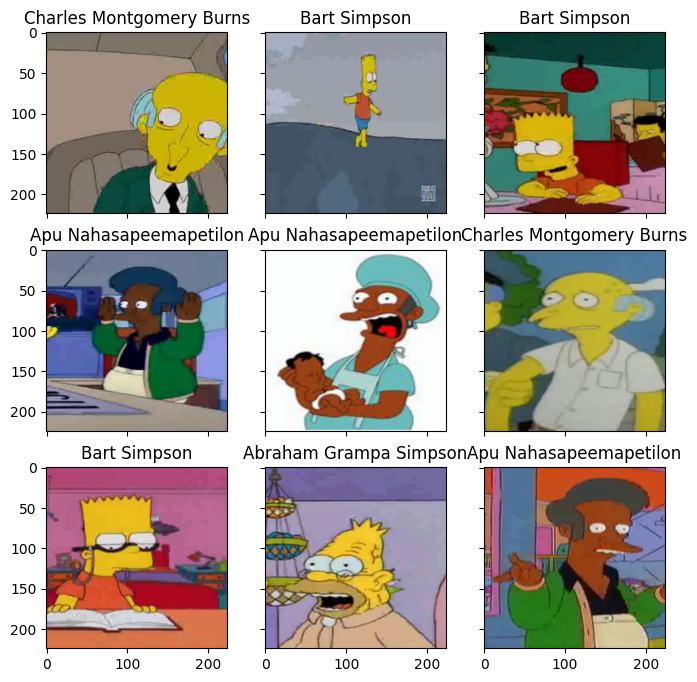

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети



`fit_epoch` выполняет одну эпоху обучения модели машинного обучения. Вот, какие действия выполняются внутри функции:

`running_loss = 0.0`: Инициализируется переменная running_loss, которая будет использоваться для накопления значения функции потерь на протяжении эпохи.

`running_corrects = 0`: Инициализируется переменная `running_corrects`, которая будет использоваться для накопления числа правильных предсказаний на протяжении эпохи.

`processed_data = 0`: Инициализируется переменная `processed_data`, которая будет хранить общее количество обработанных данных (изображений) в течение эпохи.

`for inputs, labels in train_loader:`: Начинается цикл по данным, загружаемым из `train_loader`. `train_loader` представляет собой итератор, который предоставляет обучающие данные по мере их необходимости.

`inputs = inputs.to(DEVICE)`: Входные данные (изображения) и метки переносятся на устройство (GPU или CPU), которое указано как `DEVICE`. Это может потребоваться для использования GPU для вычислений.

`optimizer.zero_grad()`: Обнуление градиентов в оптимизаторе. Это необходимо перед вычислением градиентов и обновлением параметров модели.

`outputs = model(inputs)`: Вычисление выходов модели на входных данных.

`loss = criterion(outputs, labels)`: Вычисление функции потерь между выходами модели и истинными метками (labels).

`loss.backward()`: Вычисление градиентов функции потерь по параметрам модели.

`optimizer.step()`: Обновление параметров модели с использованием оптимизатора.

`preds = torch.argmax(outputs, 1)`: Получение предсказанных классов, выбирая индекс с максимальным значением из выходных данных модели.

`running_loss += loss.item() * inputs.size(0)`: Накопление значения функции потерь для данной эпохи.

`running_corrects += torch.sum(preds == labels.data)`: Накопление числа правильных предсказаний для данной эпохи.

`processed_data += inputs.size(0)`: Накопление общего количества обработанных данных (изображений) для данной эпохи.

`train_loss = running_loss / processed_data`: Вычисление средней функции потерь для данной эпохи.

`train_acc = running_corrects.cpu().numpy() / processed_data`: Вычисление точности (accuracy) для данной эпохи. Обратите внимание на .cpu(), которое используется для переноса данных на CPU для вычисления точности.

Функция возвращает среднюю функцию потерь и точность для данной эпохи. Эти значения могут быть использованы для мониторинга процесса обучения модели.

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

`eval_epoch` выполняет одну эпоху валидации (оценки производительности модели) на валидационных данных

`model.eval()`: Устанавливает модель в режим оценки (evaluation mode), что означает, что модель не будет обучаться, и некоторые слои (например, дропаут) будут включены в режим оценки.

`running_loss = 0.0`: Инициализируется переменная `running_loss`, которая будет использоваться для накопления значения функции потерь на протяжении эпохи.

`running_corrects = 0` Инициализируется переменная `running_corrects`, которая будет использоваться для накопления числа правильных предсказаний на протяжении эпохи.

`processed_size = 0`: Инициализируется переменная `processed_size`, которая будет хранить общее количество обработанных данных (изображений) в течение эпохи.

`for inputs, labels in val_loader:`: Начинается цикл по данным, загружаемым из `val_loader`. `val_loader` представляет собой итератор, который предоставляет валидационные данные по мере их необходимости.

`inputs = inputs.to(DEVICE)`: Входные данные (изображения) и метки переносятся на устройство (GPU или CPU), которое указано как DEVICE.

`with torch.set_grad_enabled(False):`: Этот блок кода отключает вычисление градиентов во избежание избыточных вычислений градиентов в режиме оценки.

`outputs = model(inputs)`: Вычисление выходов модели на входных данных.

`loss = criterion(outputs, labels)`: Вычисление функции потерь между выходами модели и истинными метками (labels).

`preds = torch.argmax(outputs, 1)`: Получение предсказанных классов, выбирая индекс с максимальным значением из выходных данных модели.

`running_loss += loss.item() * inputs.size(0)`: Накопление значения функции потерь для данной эпохи.

`running_corrects += torch.sum(preds == labels.data)`: Накопление числа правильных предсказаний для данной эпохи.

`processed_size += inputs.size(0)`: Накопление общего количества обработанных данных (изображений) для данной эпохи.

`val_loss = running_loss / processed_size`: Вычисление средней функции потерь для данной эпохи.

`val_acc = running_corrects.double() / processed_size`: Вычисление точности (accuracy) для данной эпохи. double() используется для преобразования числа в формат с плавающей запятой для точного вычисления.

Функция возвращает среднюю функцию потерь и точность для данной эпохи валидации. Эти значения могут быть использованы для оценки производительности модели на валидационных данных.

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Функция `train` выполняет процесс обучения модели машинного обучения. Она принимает следующие аргументы:

`train_files`: Список файлов, используемых для обучения модели.<br>
`val_files`: Список файлов, используемых для валидации модели.<br>
`model`: Модель машинного обучения, которую нужно обучать.<br>
`epochs`: Количество эпох обучения (сколько раз проходить по всему обучающему набору данных).<br>
`batch_size`: Размер пакета данных для обучения (сколько изображений обрабатывать за одну итерацию обучения).

In [22]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Функция `predict` выполняет прогнозирование (предсказание) классов для данных из входного `test_loader `с использованием обученной модели `model`

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
n_classes = len(np.unique(train_val_labels))

Запустим обучение сети.

In [25]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

Загружаем предварительно обученную модель ResNet-18 из библиотеки PyTorch

In [26]:
model_resnet = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 244MB/s]


 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64

In [27]:
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = True

model_resnet.fc = nn.Sequential(nn.Linear(512,42))

In [28]:
model_resnet = model_resnet.cuda()

Запускаем обучение ...

In [29]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=30, batch_size=128)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.7763256838478642


epoch:   3%|▎         | 1/30 [03:53<1:53:01, 233.84s/it]


Epoch 001 train_loss: 0.7763     val_loss 0.5827 train_acc 0.8070 val_acc 0.8420
loss 3.1488399241667535


epoch:   7%|▋         | 2/30 [07:23<1:42:35, 219.84s/it]


Epoch 002 train_loss: 3.1488     val_loss 3.1117 train_acc 0.1077 val_acc 0.1074
loss 3.11642051227564


epoch:  10%|█         | 3/30 [10:53<1:36:52, 215.29s/it]


Epoch 003 train_loss: 3.1164     val_loss 3.1082 train_acc 0.1064 val_acc 0.1074
loss 3.113477042089018


epoch:  13%|█▎        | 4/30 [14:21<1:32:04, 212.47s/it]


Epoch 004 train_loss: 3.1135     val_loss 3.1220 train_acc 0.1061 val_acc 0.1114
loss 3.1133650752630757


epoch:  17%|█▋        | 5/30 [17:51<1:28:03, 211.32s/it]


Epoch 005 train_loss: 3.1134     val_loss 3.0871 train_acc 0.1073 val_acc 0.1087
loss 3.0392685874919767


epoch:  20%|██        | 6/30 [21:20<1:24:12, 210.53s/it]


Epoch 006 train_loss: 3.0393     val_loss 2.8944 train_acc 0.1228 val_acc 0.1486
loss 2.760876892691122


epoch:  23%|██▎       | 7/30 [24:49<1:20:31, 210.08s/it]


Epoch 007 train_loss: 2.7609     val_loss 2.5099 train_acc 0.2105 val_acc 0.2874
loss 2.3690306921052025


epoch:  27%|██▋       | 8/30 [28:18<1:16:56, 209.83s/it]


Epoch 008 train_loss: 2.3690     val_loss 2.0718 train_acc 0.3256 val_acc 0.4052
loss 1.952822369013222


epoch:  30%|███       | 9/30 [31:46<1:13:15, 209.31s/it]


Epoch 009 train_loss: 1.9528     val_loss 1.6945 train_acc 0.4542 val_acc 0.5237
loss 1.6270098097879147


epoch:  33%|███▎      | 10/30 [35:17<1:09:52, 209.63s/it]


Epoch 010 train_loss: 1.6270     val_loss 1.4102 train_acc 0.5480 val_acc 0.6081
loss 1.3930815792105002


epoch:  37%|███▋      | 11/30 [38:46<1:06:19, 209.42s/it]


Epoch 011 train_loss: 1.3931     val_loss 1.1619 train_acc 0.6129 val_acc 0.6775
loss 1.2041215875724507


epoch:  40%|████      | 12/30 [42:24<1:03:37, 212.09s/it]


Epoch 012 train_loss: 1.2041     val_loss 1.0088 train_acc 0.6623 val_acc 0.7230
loss 1.0300035681973005


epoch:  43%|████▎     | 13/30 [45:57<1:00:09, 212.34s/it]


Epoch 013 train_loss: 1.0300     val_loss 0.9148 train_acc 0.7128 val_acc 0.7489
loss 0.9556181410769989


epoch:  47%|████▋     | 14/30 [49:27<56:26, 211.66s/it]


Epoch 014 train_loss: 0.9556     val_loss 0.8248 train_acc 0.7328 val_acc 0.7761
loss 0.8347847969511207


epoch:  50%|█████     | 15/30 [52:57<52:47, 211.18s/it]


Epoch 015 train_loss: 0.8348     val_loss 0.7447 train_acc 0.7658 val_acc 0.8000
loss 0.7410142333448765


epoch:  53%|█████▎    | 16/30 [56:25<49:05, 210.38s/it]


Epoch 016 train_loss: 0.7410     val_loss 0.7574 train_acc 0.7927 val_acc 0.8034
loss 0.6679903475583241


epoch:  57%|█████▋    | 17/30 [59:56<45:35, 210.42s/it]


Epoch 017 train_loss: 0.6680     val_loss 0.7372 train_acc 0.8129 val_acc 0.8063
loss 0.6316048930982806


epoch:  60%|██████    | 18/30 [1:03:26<42:04, 210.38s/it]


Epoch 018 train_loss: 0.6316     val_loss 0.6461 train_acc 0.8230 val_acc 0.8254
loss 0.5468481357169459


epoch:  63%|██████▎   | 19/30 [1:06:55<38:28, 209.87s/it]


Epoch 019 train_loss: 0.5468     val_loss 0.6620 train_acc 0.8455 val_acc 0.8315
loss 0.5094848940103508


epoch:  67%|██████▋   | 20/30 [1:10:26<35:02, 210.25s/it]


Epoch 020 train_loss: 0.5095     val_loss 0.5951 train_acc 0.8560 val_acc 0.8451
loss 0.46407842843219255


epoch:  70%|███████   | 21/30 [1:13:55<31:29, 209.96s/it]


Epoch 021 train_loss: 0.4641     val_loss 0.5589 train_acc 0.8670 val_acc 0.8538
loss 0.4159410429199043


epoch:  73%|███████▎  | 22/30 [1:17:25<27:59, 209.99s/it]


Epoch 022 train_loss: 0.4159     val_loss 0.5235 train_acc 0.8792 val_acc 0.8724
loss 0.3795166626630509


epoch:  77%|███████▋  | 23/30 [1:20:55<24:29, 209.89s/it]


Epoch 023 train_loss: 0.3795     val_loss 0.5362 train_acc 0.8915 val_acc 0.8607
loss 0.3603691610713105


epoch:  80%|████████  | 24/30 [1:24:24<20:57, 209.55s/it]


Epoch 024 train_loss: 0.3604     val_loss 0.5099 train_acc 0.8945 val_acc 0.8760
loss 0.3361532443765243


epoch:  83%|████████▎ | 25/30 [1:27:54<17:29, 209.82s/it]


Epoch 025 train_loss: 0.3362     val_loss 0.5142 train_acc 0.9029 val_acc 0.8724
loss 0.29235916010998897


epoch:  87%|████████▋ | 26/30 [1:31:27<14:03, 210.77s/it]


Epoch 026 train_loss: 0.2924     val_loss 0.5515 train_acc 0.9136 val_acc 0.8666
loss 0.27658476248783126


epoch:  90%|█████████ | 27/30 [1:34:57<10:31, 210.53s/it]


Epoch 027 train_loss: 0.2766     val_loss 0.5038 train_acc 0.9169 val_acc 0.8722
loss 0.259610368177476


epoch:  93%|█████████▎| 28/30 [1:38:27<07:00, 210.37s/it]


Epoch 028 train_loss: 0.2596     val_loss 0.5468 train_acc 0.9226 val_acc 0.8741
loss 0.2558408326362757


epoch:  97%|█████████▋| 29/30 [1:41:57<03:30, 210.24s/it]


Epoch 029 train_loss: 0.2558     val_loss 0.5257 train_acc 0.9241 val_acc 0.8836
loss 0.22071383540110495


epoch: 100%|██████████| 30/30 [1:45:27<00:00, 210.93s/it]


Epoch 030 train_loss: 0.2207     val_loss 0.5382 train_acc 0.9335 val_acc 0.8865


Построим кривые обучения

In [38]:
loss, acc, val_loss, val_acc = zip(*history)

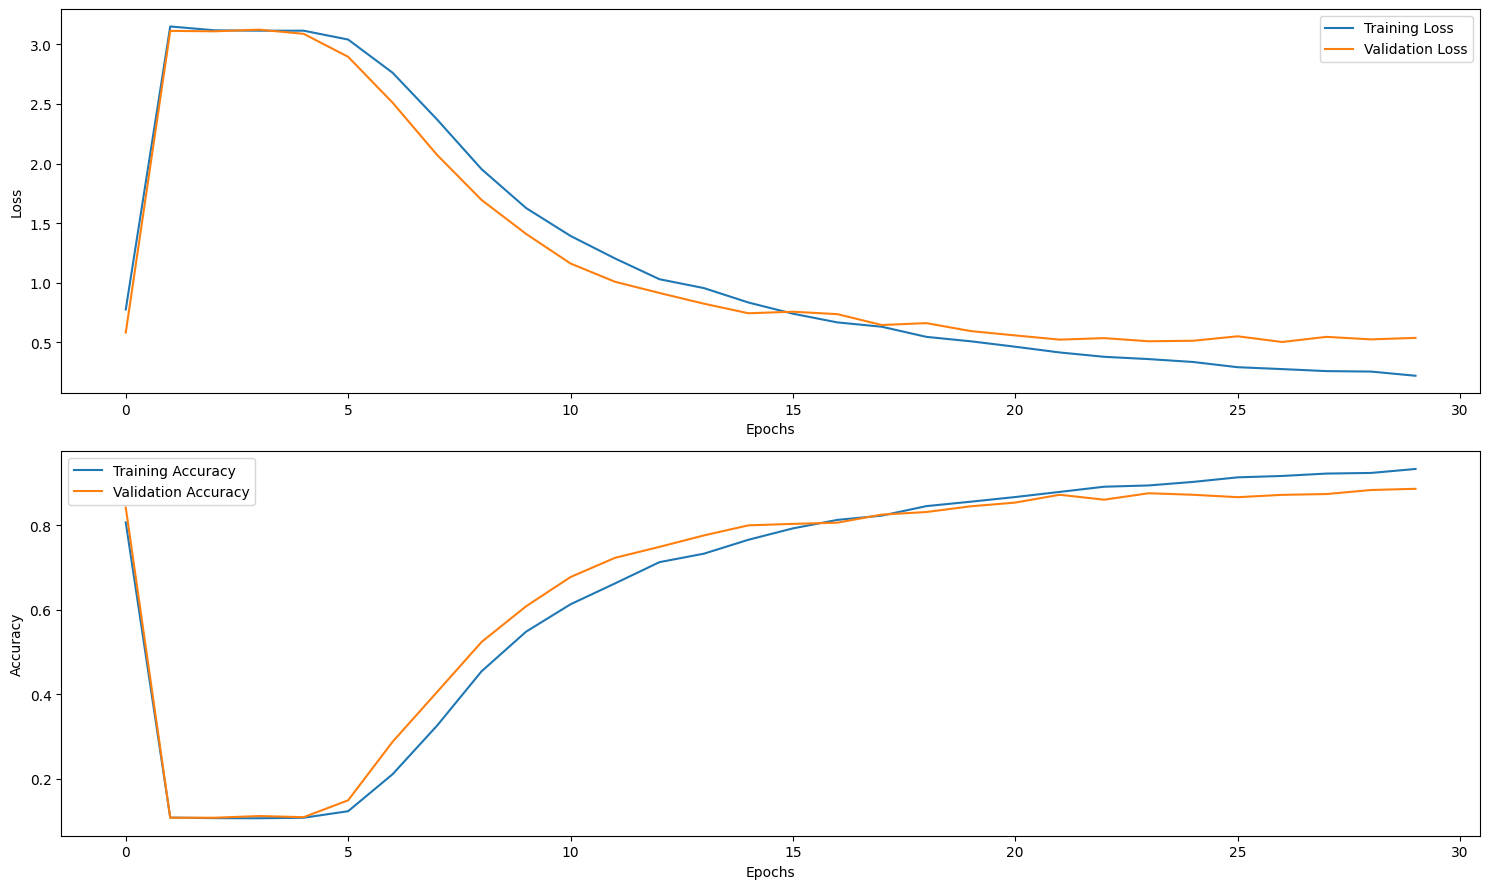

In [41]:
# Переносим данные с GPU на CPU, если они находятся на GPU
loss = [l.cpu().numpy() if isinstance(l, torch.Tensor) else l for l in loss]
acc = [a.cpu().numpy() if isinstance(a, torch.Tensor) else a for a in acc]
val_loss = [vl.cpu().numpy() if isinstance(vl, torch.Tensor) else vl for vl in val_loss]
val_acc = [va.cpu().numpy() if isinstance(va, torch.Tensor) else va for va in val_acc]

plt.figure(figsize=(15, 9))

# График для функции потерь
plt.subplot(2, 1, 1)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")

# График для точности
plt.subplot(2, 1, 2)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()  # Для улучшения компоновки графиков на фигуре
plt.show()


Сохраним модель

In [52]:
torch.save(model_resnet.state_dict(), 'ResNet18_30_epoch.pth')

In [42]:
model_resnet.load_state_dict(torch.load('ResNet18_30_epoch.pth'))

<All keys matched successfully>

In [43]:
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.24000876255798995


epoch:  20%|██        | 1/5 [03:30<14:03, 210.83s/it]


Epoch 001 train_loss: 0.2400     val_loss 0.4680 train_acc 0.9289 val_acc 0.8940
loss 0.19929880779316048


epoch:  40%|████      | 2/5 [07:02<10:34, 211.60s/it]


Epoch 002 train_loss: 0.1993     val_loss 0.4794 train_acc 0.9411 val_acc 0.8880
loss 0.19529166775711387


epoch:  60%|██████    | 3/5 [10:32<07:01, 210.88s/it]


Epoch 003 train_loss: 0.1953     val_loss 0.5134 train_acc 0.9404 val_acc 0.8865
loss 0.17960506368764714


epoch:  80%|████████  | 4/5 [14:04<03:31, 211.29s/it]


Epoch 004 train_loss: 0.1796     val_loss 0.4999 train_acc 0.9465 val_acc 0.8991
loss 0.1646158529854981


epoch: 100%|██████████| 5/5 [17:34<00:00, 210.99s/it]


Epoch 005 train_loss: 0.1646     val_loss 0.4715 train_acc 0.9491 val_acc 0.8951


У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному класс

In [45]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [46]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

In [48]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet, imgs)

In [49]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [50]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах

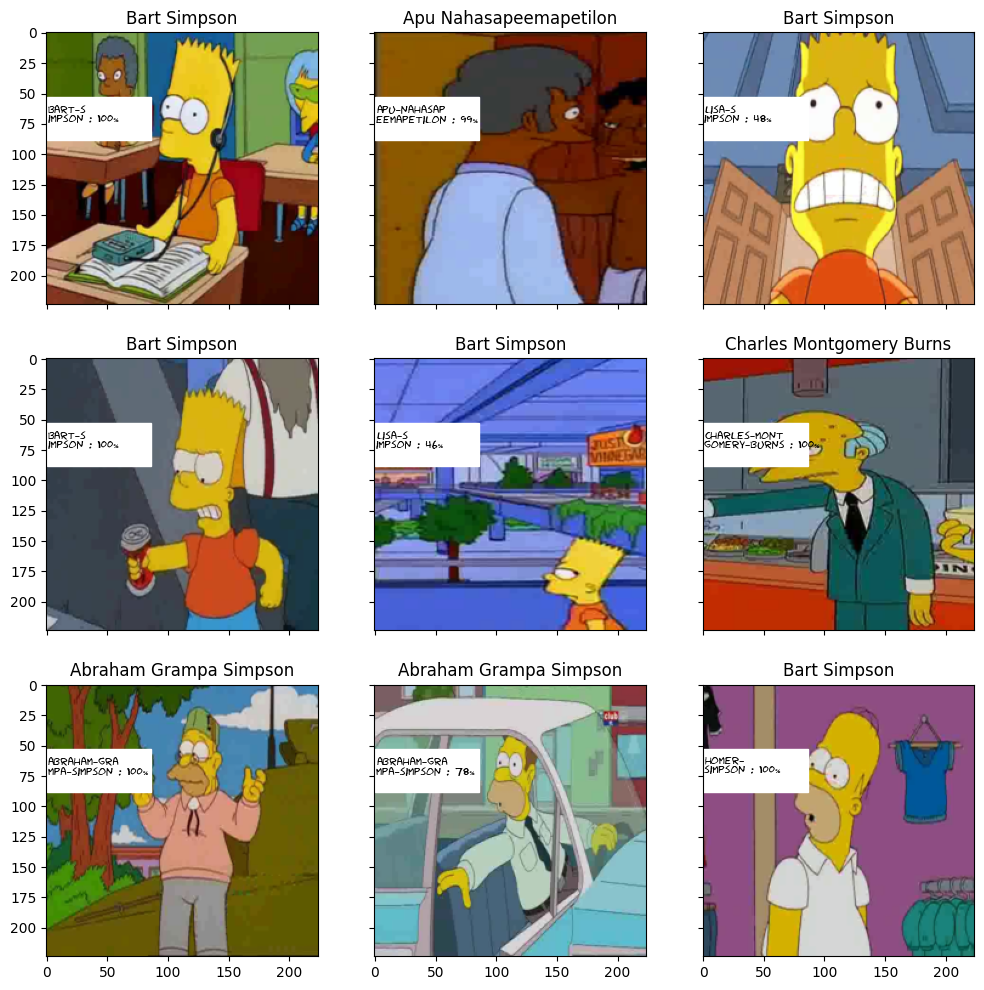

In [51]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')